In [8]:
import pandas as pd
#pip install prophet
#pip install ipywidgets
from prophet import Prophet
import itertools
import numpy as np

import sys
sys.path.append('/Users/thomas_metral/code/thomas-metral/metro_seoul')
# print(sys.path)


from prophet.plot import plot_plotly, plot_components_plotly
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
import matplotlib.pyplot as plt
import seaborn as sns
from metro_app.ml_logic.preprocess import general_preprocessing, model_data_preprocessing, preprocess_lstm, prophet_preprocessing_one_station

from metro_app.ml_logic.model import prophet_train_predict, plot_evaluate
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_squared_error
import datetime
import plotly.express as px

%matplotlib inline
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
df = pd.read_csv('/Users/thomas_metral/code/thomas-metral/metro_seoul/raw_data/crowd2020-2023.csv')


/var/folders/zn/b4l6fdhd4fs52t3wxt1d7kn40000gn/T/ipykernel_69889/2845828255.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/Users/thomas_metral/code/thomas-metral/metro_seoul/raw_data/crowd2020-2023.csv')


## Multi station

In [4]:
df1 = general_preprocessing(df)
df1 = model_data_preprocessing(df1)
df1.reset_index(inplace=True)
df1 = df1.groupby(['datetime', 'station_name', 'station_number', 'line'])['value'].sum().reset_index()
df1


NameError: name 'df' is not defined

In [276]:
station_charlotte = [['Dongjak (Seoul National Cemetery)', 4],
 ['Gangnam', 2],
 ['Gireum', 4],
 ['Guro Digital Complex', 2],
 ['Gwanghwamun(Sejong Center for the Performing Arts)', 5],
 ['Hongik Univ.', 2],
 ['Itaewon', 6],
 ['Jamsilsaenae', 2],
 ['Mok-dong', 5],
 ['Nokbeon', 3],
 ['Seongsu', 2],
 ['Seoul Station', 1],
 ['Seoul Station', 4],
 ['World Cup Stadium(Seongsan)', 6],
 ['Yeonsinnae', 3],
 ['Yeonsinnae', 6],
 ['Yeouido', 5]]

mapes2 = []
results = []
for i in range(len(station_charlotte)):

    data = df1[(df1['station_name'] == station_charlotte[i][0]) &
                (df1['line'] == station_charlotte[i][1])]
    data = data.rename(columns={'datetime':'ds', 'value' : 'y'})

    #lenght of test data
    days = 2

    # index = round(train_size*df_156.shape[0])
    data_train = data.iloc[:-24*days]
    data_test = data.iloc[-24*days:]

    #shorten the train data
    data_train = data_train.iloc[-24*500:]

    data_train['is_morning_peak'] = ((data_train['ds'].dt.hour == 8) & (data_train['ds'].dt.dayofweek <= 5)).astype(int)
    data_train['is_afternoon_peak'] = ((data_train['ds'].dt.hour == 18) & (data_train['ds'].dt.dayofweek <= 5)).astype(int)
    data_train['is_closed'] = ((data_train['ds'].dt.hour >= 0) & (data_train['ds'].dt.hour <= 4)).astype(int)

    model = Prophet(changepoint_prior_scale=0.2, seasonality_prior_scale=10.0,
                    holidays_prior_scale=10.0, seasonality_mode='multiplicative')
    # model.add_regressor('is_morning_peak')
    # model.add_regressor('is_afternoon_peak')

    model.add_regressor('is_closed', mode='multiplicative')
    model.add_seasonality(name='morning_peak', period=1, fourier_order=8, condition_name='is_morning_peak')
    model.add_seasonality(name='afternoon_peak', period=1, fourier_order=8, condition_name='is_afternoon_peak')
    model.add_country_holidays(country_name='SK')
    model.fit(data_train)


    # Create a future dataframe for predictions
    future = model.make_future_dataframe(periods=days*24, include_history=False, freq='h')  # Forecasting for the next week
    future['is_morning_peak'] = ((future['ds'].dt.hour >= 7) & (future['ds'].dt.hour <= 9)).astype(int)
    future['is_afternoon_peak'] = ((future['ds'].dt.hour >= 17) & (future['ds'].dt.hour <= 19)).astype(int)
    future['is_closed'] = ((future['ds'].dt.hour >= 0) & (future['ds'].dt.hour <= 4)).astype(int)
    future['is_weekend'] = (future['ds'].dt.dayofweek >= 5).astype(int)

    # Generate predictions
    forecast = model.predict(future)
    forecast.loc[forecast['is_closed'] != 0, 'yhat'] = 0
    forecast.loc[forecast['morning_peak'] > 2, 'yhat'] = forecast.loc[forecast['morning_peak'] > 2, 'yhat'] * 1.2
    forecast.loc[forecast['afternoon_peak'] > 2, 'yhat'] = forecast.loc[forecast['afternoon_peak'] > 2, 'yhat'] * 1.18
    prediction = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

    result = mape(prediction['yhat'].values, data_test['y'].values)
    results.append(result)
    mapes2.append(f"{station_charlotte[i][0]} {station_charlotte[i][1]} : {result}")


12:08:31 - cmdstanpy - INFO - Chain [1] start processing
12:08:33 - cmdstanpy - INFO - Chain [1] done processing
12:08:34 - cmdstanpy - INFO - Chain [1] start processing
12:08:36 - cmdstanpy - INFO - Chain [1] done processing
12:08:37 - cmdstanpy - INFO - Chain [1] start processing
12:08:39 - cmdstanpy - INFO - Chain [1] done processing
12:08:40 - cmdstanpy - INFO - Chain [1] start processing
12:08:42 - cmdstanpy - INFO - Chain [1] done processing
12:08:43 - cmdstanpy - INFO - Chain [1] start processing
12:08:45 - cmdstanpy - INFO - Chain [1] done processing
12:08:46 - cmdstanpy - INFO - Chain [1] start processing
12:08:49 - cmdstanpy - INFO - Chain [1] done processing
12:08:50 - cmdstanpy - INFO - Chain [1] start processing
12:08:54 - cmdstanpy - INFO - Chain [1] done processing
12:08:55 - cmdstanpy - INFO - Chain [1] start processing
12:08:57 - cmdstanpy - INFO - Chain [1] done processing
12:08:58 - cmdstanpy - INFO - Chain [1] start processing
12:08:59 - cmdstanpy - INFO - Chain [1]

In [277]:
np.mean(results)


0.15508006887882142

## Improving params

In [2]:
df = pd.read_csv('/Users/thomas_metral/code/thomas-metral/metro_seoul/raw_data/crowd2020-2023.csv')
df1 = general_preprocessing(df)
df2 = model_data_preprocessing(df1)
df2.reset_index(inplace=True)
df3 = df2.groupby(['datetime', 'station_name', 'station_number', 'line'])['value'].sum().reset_index()
data = df3[(df3['station_name'] == 'Seongsu') &
                (df3['line'] == 2)]

data = data.rename(columns={'datetime':'ds', 'value' : 'y'})


/var/folders/zn/b4l6fdhd4fs52t3wxt1d7kn40000gn/T/ipykernel_70086/364441125.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/Users/thomas_metral/code/thomas-metral/metro_seoul/raw_data/crowd2020-2023.csv')
/Users/thomas_metral/code/thomas-metral/metro_seoul/metro_app/ml_logic/preprocess.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df['date'])
/Users/thomas_metral/code/thomas-metral/metro_seoul/metro_app/ml_logic/preprocess.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

In [18]:
model, mape_prophet, prediction = prophet_train_predict(data)


15:14:05 - cmdstanpy - INFO - Chain [1] start processing
15:14:07 - cmdstanpy - INFO - Chain [1] done processing


Index(['ds', 'is_morning_peak', 'is_afternoon_peak', 'is_closed',
       'is_weekend'],
      dtype='object')
                    ds  is_morning_peak  is_afternoon_peak  is_closed  \
0  2023-06-28 01:00:00                0                  0          1   
1  2023-06-28 02:00:00                0                  0          1   
2  2023-06-28 03:00:00                0                  0          1   
3  2023-06-28 04:00:00                0                  0          1   
4  2023-06-28 05:00:00                0                  0          0   
5  2023-06-28 06:00:00                0                  0          0   
6  2023-06-28 07:00:00                0                  0          0   
7  2023-06-28 08:00:00                1                  0          0   
8  2023-06-28 09:00:00                1                  0          0   
9  2023-06-28 10:00:00                0                  0          0   
10 2023-06-28 11:00:00                0                  0          0   
11 2023-06-28 

In [19]:
prediction


,ds,yhat
0,2023-06-28 01:00:00,0.000000
1,2023-06-28 02:00:00,0.000000
2,2023-06-28 03:00:00,0.000000
3,2023-06-28 04:00:00,0.000000
4,2023-06-28 05:00:00,933.598492
...,...,...
67,2023-06-30 20:00:00,4074.049680
68,2023-06-30 21:00:00,2907.606769
69,2023-06-30 22:00:00,1745.161209
70,2023-06-30 23:00:00,910.583700


In [14]:
plot_evaluate(data, prediction)


### Feature engineering

In [25]:
#lenght of test data
days = 3

# index = round(train_size*df_156.shape[0])
data_train = data.iloc[:-24*days]
data_test = data.iloc[-24*days:]

#shorten the train data
data_train = data_train.iloc[-24*500:]

data_train['is_morning_peak'] = ((data_train['ds'].dt.hour == 8) & (data_train['ds'].dt.dayofweek <= 5)).astype(int)
data_train['is_afternoon_peak'] = ((data_train['ds'].dt.hour == 18) & (data_train['ds'].dt.dayofweek <= 5)).astype(int)
data_train['is_closed'] = ((data_train['ds'].dt.hour >= 0) & (data_train['ds'].dt.hour <= 4)).astype(int)


In [29]:
#instantiate and fit the model
model = Prophet(changepoint_prior_scale=0.2, seasonality_prior_scale=10.0,
                holidays_prior_scale=10.0, seasonality_mode='multiplicative')
# model.add_regressor('is_morning_peak')
# model.add_regressor('is_afternoon_peak')

model.add_regressor('is_closed', mode='multiplicative')
model.add_seasonality(name='morning_peak', period=1, fourier_order=8, condition_name='is_morning_peak')
model.add_seasonality(name='afternoon_peak', period=1, fourier_order=8, condition_name='is_afternoon_peak')
model.add_country_holidays(country_name='SK')
model.fit(data_train)

# Create a future dataframe for predictions
future = model.make_future_dataframe(periods=days*24, include_history=False, freq='h')  # Forecasting for the next week
future['is_morning_peak'] = ((future['ds'].dt.hour >= 8) & (future['ds'].dt.hour <= 9) & (future['ds'].dt.dayofweek <= 5)).astype(int)
future['is_afternoon_peak'] = ((future['ds'].dt.hour >= 17) & (future['ds'].dt.hour <= 19) & (future['ds'].dt.dayofweek <= 5)).astype(int)
future['is_closed'] = ((future['ds'].dt.hour >= 0) & (future['ds'].dt.hour <= 4)).astype(int)
future['is_weekend'] = (future['ds'].dt.dayofweek >= 5).astype(int)

# Generate predictions
forecast = model.predict(future)
forecast.loc[forecast['is_closed'] != 0, 'yhat'] = 0
forecast.loc[forecast['morning_peak'] > 2, 'yhat'] = forecast.loc[forecast['morning_peak'] > 2, 'yhat'] * 1.2
forecast.loc[forecast['afternoon_peak'] > 2, 'yhat'] = forecast.loc[forecast['afternoon_peak'] > 2, 'yhat'] * 1.18


prediction = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

mape(prediction['yhat'].values, data_test['y'].values)


15:20:00 - cmdstanpy - INFO - Chain [1] start processing
15:20:02 - cmdstanpy - INFO - Chain [1] done processing


0.13995927395036076

In [291]:
comparaison = prediction.merge(data_test, on='ds')
fig = px.line(comparaison, x="ds", y=["y", 'yhat'])

fig.show()


/Users/thomas_metral/.pyenv/versions/3.10.6/envs/metro_seoul/lib/python3.10/site-packages/prophet/plot.py:72: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/Users/thomas_metral/.pyenv/versions/3.10.6/envs/metro_seoul/lib/python3.10/site-packages/prophet/plot.py:73: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



KeyError: 'yhat'

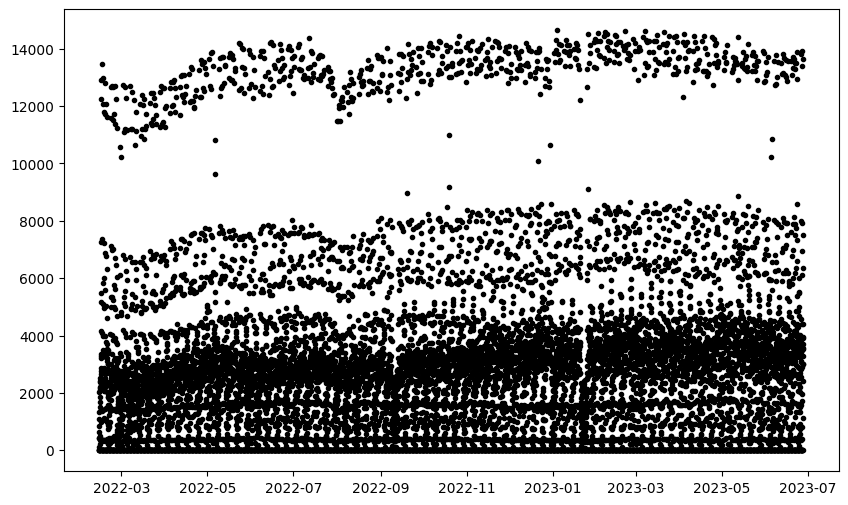

In [30]:
ax = model.plot(future)
plt.plot(data_test['ds'],data_test['y'],'r')
plt.xlim(left=(pd.Timestamp(max(data_test.ds)-datetime.timedelta(days=5))),
right=(pd.Timestamp(max(data_test.ds)+ datetime.timedelta(days=1)))
)
plt.show()


### CROSS VAL

In [136]:
param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1],
    'seasonality_prior_scale': [0.1, 1.0, 10.0],
    'holidays_prior_scale' : [1.0, 10.0, 15.0],
    'seasonality_mode' : ['multiplicative']

}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params)  # Fit model with given params
    m.add_regressor('is_closed', mode='multiplicative')
    m.add_seasonality(name='morning_peak', period=1, fourier_order=8, condition_name='is_morning_peak')
    m.add_seasonality(name='afternoon_peak', period=1, fourier_order=8, condition_name='is_afternoon_peak')
    m.add_country_holidays(country_name='SK')
    m.fit(data_train)
    df_cv = cross_validation(m, initial='400 days', period='100 days', horizon = '2 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)
tuning_results.iloc[rmses.index(min(rmses))]


17:51:44 - cmdstanpy - INFO - Chain [1] start processing
17:51:45 - cmdstanpy - INFO - Chain [1] done processing
17:51:46 - cmdstanpy - INFO - Chain [1] start processing
17:51:46 - cmdstanpy - INFO - Chain [1] done processing
17:51:47 - cmdstanpy - INFO - Chain [1] start processing
17:51:47 - cmdstanpy - INFO - Chain [1] done processing
17:51:49 - cmdstanpy - INFO - Chain [1] start processing
17:51:49 - cmdstanpy - INFO - Chain [1] done processing
17:51:50 - cmdstanpy - INFO - Chain [1] start processing
17:51:50 - cmdstanpy - INFO - Chain [1] done processing
17:51:51 - cmdstanpy - INFO - Chain [1] start processing
17:51:52 - cmdstanpy - INFO - Chain [1] done processing
17:51:53 - cmdstanpy - INFO - Chain [1] start processing
17:51:53 - cmdstanpy - INFO - Chain [1] done processing
17:51:54 - cmdstanpy - INFO - Chain [1] start processing
17:51:55 - cmdstanpy - INFO - Chain [1] done processing
17:51:56 - cmdstanpy - INFO - Chain [1] start processing
17:51:56 - cmdstanpy - INFO - Chain [1]

    changepoint_prior_scale  seasonality_prior_scale  holidays_prior_scale  \
0                     0.001                      0.1                   1.0   
1                     0.001                      0.1                  10.0   
2                     0.001                      0.1                  15.0   
3                     0.001                      1.0                   1.0   
4                     0.001                      1.0                  10.0   
5                     0.001                      1.0                  15.0   
6                     0.001                     10.0                   1.0   
7                     0.001                     10.0                  10.0   
8                     0.001                     10.0                  15.0   
9                     0.010                      0.1                   1.0   
10                    0.010                      0.1                  10.0   
11                    0.010                      0.1            

17:53:31 - cmdstanpy - INFO - Chain [1] done processing


changepoint_prior_scale               0.1
seasonality_prior_scale               0.1
holidays_prior_scale                 15.0
seasonality_mode           multiplicative
rmse                          2013.490298
Name: 20, dtype: object

# Achasan 5

## Train/Test split

In [12]:
#lenght of test data
days = 2

# index = round(train_size*df_156.shape[0])
df_achasan5_train = df_achasan5.iloc[:-24*days]
df_achasan5_test = df_achasan5.iloc[-24*days:]

#shorten the train data
df_achasan5_train = df_achasan5_train.iloc[-24*365:]


NameError: name 'df_achasan5' is not defined

## Adding columns for regressor

In [90]:
df_achasan5_train['is_morning_peak'] = ((df_achasan5_train['ds'].dt.hour == 8) & (df_achasan5_train['ds'].dt.dayofweek <= 5)).astype(int)
df_achasan5_train['is_afternoon_peak'] = ((df_achasan5_train['ds'].dt.hour == 18) & (df_achasan5_train['ds'].dt.dayofweek <= 5)).astype(int)
df_achasan5_train['is_closed'] = ((df_achasan5_train['ds'].dt.hour >= 0) & (df_achasan5_train['ds'].dt.hour <= 4)).astype(int)
df_achasan5_train.sample(18)


,ds,y,is_morning_peak,is_afternoon_peak,is_closed,is_weekend
23988,2022-09-26 13:00:00,603.0,0,0,0,0
18771,2022-02-21 04:00:00,0.0,0,0,1,0
19250,2022-03-13 03:00:00,0.0,0,0,1,1
19890,2022-04-08 19:00:00,1520.0,0,0,0,0
23365,2022-08-31 14:00:00,501.0,0,0,0,0
22607,2022-07-31 00:00:00,0.0,0,0,1,1
25551,2022-11-30 16:00:00,941.0,0,0,0,0
26092,2022-12-23 05:00:00,46.0,0,0,0,0
24934,2022-11-04 23:00:00,447.0,0,0,0,0
23087,2022-08-20 00:00:00,0.0,0,0,1,1


## Train/Predict

In [91]:
model = Prophet(changepoint_prior_scale=0.002, seasonality_prior_scale=12.0,
                  holidays_prior_scale=10.0, seasonality_mode='multiplicative', daily_seasonality=True)
model.add_regressor('is_morning_peak')
model.add_regressor('is_afternoon_peak')
model.add_regressor('is_closed')
model.add_seasonality('daily', period=24, fourier_order=2)
model.add_country_holidays(country_name='SK')

model.fit(df_achasan5_train)


# Create a future dataframe for predictions
future = model.make_future_dataframe(periods=days*24, include_history=False, freq='h')  # Forecasting for the next week
future['is_morning_peak'] = ((future['ds'].dt.hour >= 7) & (future['ds'].dt.hour <= 9)).astype(int)
future['is_afternoon_peak'] = ((future['ds'].dt.hour >= 17) & (future['ds'].dt.hour <= 19)).astype(int)
future['is_closed'] = ((future['ds'].dt.hour >= 0) & (future['ds'].dt.hour <= 4)).astype(int)
future['is_weekend'] = (future['ds'].dt.dayofweek >= 5).astype(int)

# Generate predictions
forecast = model.predict(future)
prediction = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]


14:59:56 - cmdstanpy - INFO - Chain [1] start processing
14:59:56 - cmdstanpy - INFO - Chain [1] done processing


## Check results

0.43058828484551587

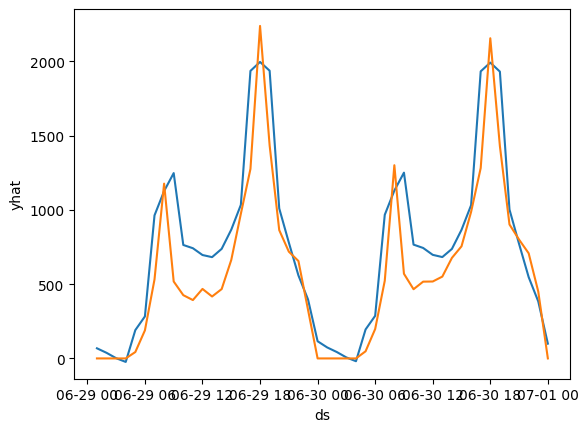

In [92]:
sns.lineplot(x=prediction['ds'], y=prediction['yhat'])
sns.lineplot(x=df_achasan5_test['ds'], y=df_achasan5_test['y'])

mape(prediction['yhat'].values, df_achasan5_test['y'].values)


/Users/thomas_metral/.pyenv/versions/3.10.6/envs/metro_seoul/lib/python3.10/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/thomas_metral/.pyenv/versions/3.10.6/envs/metro_seoul/lib/python3.10/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


NameError: name 'df_achasan5_test' is not defined

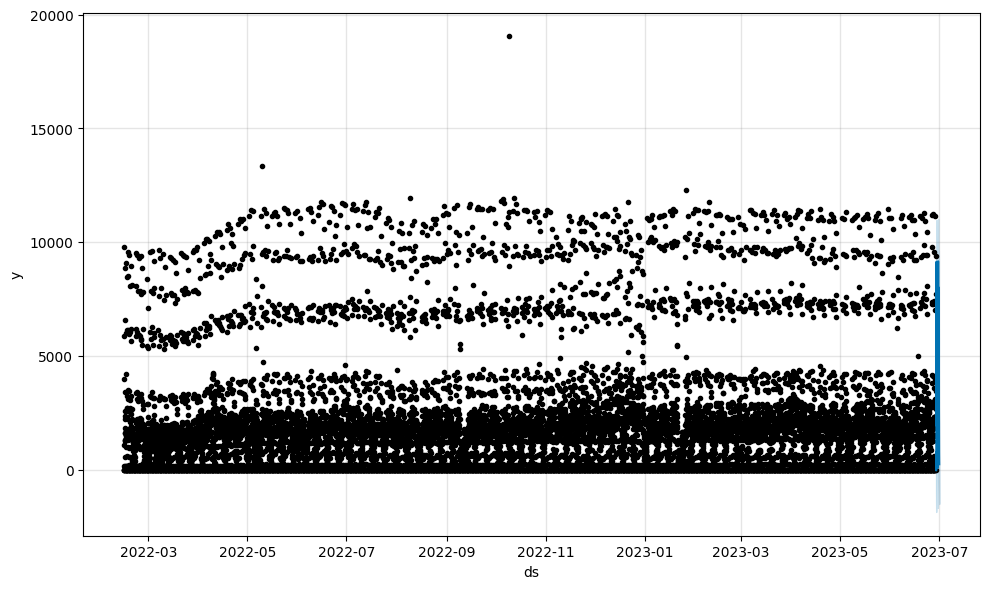

In [19]:
ax = model.plot(forecast)
plt.plot(df_achasan5_test['ds'],df_achasan5_test['y'],'r')
plt.xlim(left=(pd.Timestamp(max(df_achasan5.ds)-datetime.timedelta(days=5))),
right=(pd.Timestamp(max(df_achasan5.ds)+ datetime.timedelta(days=1)))
)
plt.show()


### Cross Validation with grid search

In [34]:
param_grid = {
    'changepoint_prior_scale': [0.001, 0.002, 0.003],
    'seasonality_prior_scale': [10.0, 12.0, 20.0],
    'holidays_prior_scale' : [9.0, 10.0, 15.0],
    'seasonality_mode' : ['multiplicative']

}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params)  # Fit model with given params
    m.add_country_holidays(country_name='KR')
    m.add_regressor('is_morning_peak')
    m.add_regressor('is_afternoon_peak')
    m.add_regressor('is_closed')
    m.fit(df_achasan5_train)
    df_cv = cross_validation(m, initial='400 days', period='100 days', horizon = '2 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)
tuning_results.iloc[rmses.index(min(rmses))]


14:14:00 - cmdstanpy - INFO - Chain [1] start processing
14:14:00 - cmdstanpy - INFO - Chain [1] done processing
14:14:01 - cmdstanpy - INFO - Chain [1] start processing
14:14:02 - cmdstanpy - INFO - Chain [1] done processing
14:14:02 - cmdstanpy - INFO - Chain [1] start processing
14:14:03 - cmdstanpy - INFO - Chain [1] done processing
14:14:04 - cmdstanpy - INFO - Chain [1] start processing
14:14:04 - cmdstanpy - INFO - Chain [1] done processing
14:14:05 - cmdstanpy - INFO - Chain [1] start processing
14:14:05 - cmdstanpy - INFO - Chain [1] done processing
14:14:06 - cmdstanpy - INFO - Chain [1] start processing
14:14:07 - cmdstanpy - INFO - Chain [1] done processing
14:14:07 - cmdstanpy - INFO - Chain [1] start processing
14:14:08 - cmdstanpy - INFO - Chain [1] done processing
14:14:08 - cmdstanpy - INFO - Chain [1] start processing
14:14:09 - cmdstanpy - INFO - Chain [1] done processing
14:14:09 - cmdstanpy - INFO - Chain [1] start processing
14:14:10 - cmdstanpy - INFO - Chain [1]

    changepoint_prior_scale  seasonality_prior_scale  holidays_prior_scale  \
0                     0.001                     10.0                   9.0   
1                     0.001                     10.0                  10.0   
2                     0.001                     10.0                  15.0   
3                     0.001                     12.0                   9.0   
4                     0.001                     12.0                  10.0   
5                     0.001                     12.0                  15.0   
6                     0.001                     20.0                   9.0   
7                     0.001                     20.0                  10.0   
8                     0.001                     20.0                  15.0   
9                     0.002                     10.0                   9.0   
10                    0.002                     10.0                  10.0   
11                    0.002                     10.0            

14:15:14 - cmdstanpy - INFO - Chain [1] done processing


changepoint_prior_scale             0.003
seasonality_prior_scale              12.0
holidays_prior_scale                 10.0
seasonality_mode           multiplicative
rmse                           159.299028
Name: 22, dtype: object

In [35]:

np.sqrt(mean_squared_error(prediction['yhat'].values, df_achasan5_test['y'].values))


251.06858634542422

In [36]:
df_p


,horizon,mse,rmse,mae,mdape,smape,coverage
0,2 days,26063.986303,161.443446,125.170957,0.217973,0.604893,0.895833
